In [2]:
pip install python-mnist==0.5 # 다운받은 data 불러오는 라이브러리

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-mnist: filename=python_mnist-0.5-py3-none-any.whl size=11114 sha256=1957bc1dbabdcadf99f5e379865231bc324afd486bbcea4faa41c0a2a5534796
  Stored in directory: /root/.cache/pip/wheels/67/d1/46/43124d12260cf439a101157c358c8c2df565fd1744fa81a742
Successfully built python-mnist


In [3]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import random

from mnist import MNIST

import torch.utils.data as data_utils
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)

if device=='cuda':
  torch.cuda.manual_seed(777)

cpu


# Load Dataset and Preprocessing

In [70]:
mnist = MNIST("/content/drive/MyDrive/Colab Notebooks/data/raw")

x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print("x_train의 shape = {}, y_train의 shape = {}".format(x_train.shape, y_train.shape))
print("x_test이 shape = {}, y_test의 shape = {}".format(x_test.shape, y_test.shape))

x_train의 shape = (60000, 784), y_train의 shape = (60000,)
x_test이 shape = (10000, 784), y_test의 shape = (10000,)


# Convert Dataset into Tensor

In [71]:
traindata = data_utils.TensorDataset(torch.FloatTensor(x_train), 
                                     torch.FloatTensor(y_train))

batch_size = 1000
trainloader = data_utils.DataLoader(traindata, batch_size=batch_size, shuffle=True)

# Dropout Model 1

- p=1 means switch off all activations
  - p=1인 경우, 모든 노드를 다 죽인다는 의미

- p 값이 높을수록, 드랍아웃되는 노드가 증가

In [72]:
# p – probability of an element to be zeroed. Default: 0.5 => 0으로 만들어줄 확률, 쉬운 이해를 위해 아래 예시를 참조
drop_prob1 = 0.4 # 40%는 out
drop_prob2 = 0.25 # 25%는 out

class Dropout(nn.Module):
    def __init__(self):
        super(Dropout, self).__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)

        self.dp1 = nn.Dropout(p = drop_prob1)
        self.dp2 = nn.Dropout(p = drop_prob2)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h1dp = self.dp1(h1)
        
        h2 = F.relu(self.fc2(h1dp))
        h2dp = self.dp2(h2)
        
        output = self.fc3(h2dp)
            
        return output

model = Dropout().to(device)

In [73]:
model

Dropout(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dp1): Dropout(p=0.4, inplace=False)
  (dp2): Dropout(p=0.25, inplace=False)
)

## Set Parameters

In [74]:
epoch = 15
learning_rate = 0.01
weight_decay = 1e-5

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Train

In [75]:
# model = Dropout().to(device)

loss_list = []

for epoch_num in range(epoch):
    model.train()
    average_loss = 0
    
    for batch_idx, (images, labels) in enumerate(trainloader):
        num_of_mini_batch = len(trainloader)
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        predicted = model(images)
        
        labels_long = torch.tensor(labels, dtype = torch.long)
        labels_long = labels_long.to(device)
        
        loss = loss_function(predicted, labels_long)
        
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        
        average_loss += (loss.item()/num_of_mini_batch)
   
    print("Epoch = {}\tAverage loss = {}".format((epoch_num+1), average_loss))

Epoch = 1	Average loss = 7.822008808453878
Epoch = 2	Average loss = 1.7239227732022597
Epoch = 3	Average loss = 1.4038846433162688
Epoch = 4	Average loss = 1.1198194632927578
Epoch = 5	Average loss = 0.8912565052509307
Epoch = 6	Average loss = 0.7597742279370625
Epoch = 7	Average loss = 0.7015770266453425
Epoch = 8	Average loss = 0.6479022443294526
Epoch = 9	Average loss = 0.6088137010733288
Epoch = 10	Average loss = 0.5920371313889823
Epoch = 11	Average loss = 0.5693769042690594
Epoch = 12	Average loss = 0.554841581483682
Epoch = 13	Average loss = 0.5352320070068041
Epoch = 14	Average loss = 0.5213584462801615
Epoch = 15	Average loss = 0.5100474342703819


## Check 3rd Epoch Average Loss

In [76]:
epoch_loss = 0

for i in range(60):
  epoch_loss = epoch_loss + loss_list[i+120]

print(epoch_loss/60)

1.4038846433162688


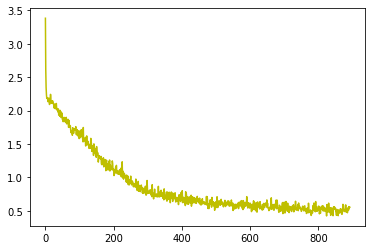

In [77]:
plt.plot(np.array(loss_list[7:]), 'y')

In [78]:
import pickle

with open('Dropout.pickle', 'wb') as f:
  pickle.dump(loss_list, f)

## Test

In [29]:
test_data = data_utils.TensorDataset(torch.FloatTensor(x_test),
                                     torch.FloatTensor(y_test))

testloader = data_utils.DataLoader(test_data, batch_size=5000, shuffle=False)

In [31]:
with torch.no_grad():
    model.eval() #test시에는 모든 node를 사용해야 하기 때문에 model.eval()를 통해 test set임을 알려줌.
    num_total_data = 0
    correct = 0
    
    for _, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        output_sftmax = F.softmax(output) # torch.nn.functional.softmax = F.softmax
        
        predicted = torch.argmax(output_sftmax, dim=1)
        
        num_total_data += len(images)
        
        answer = sum(labels == predicted).item()
        correct += answer
        
    print("Dropout 을 사용한 accuracy = %.2f%%" %((correct/num_total_data)*100))

Dropout 을 사용한 accuracy = 93.34%


- drop_prob1 = 0.5
- drop_prob2 = 0.3으로 설정해서 돌려보기

# Dropout Model2

In [61]:
# p – probability of an element to be zeroed. Default: 0.5 => 0으로 만들어줄 확률, 쉬운 이해를 위해 아래 예시를 참조
drop_prob1 = 0.5 
drop_prob2 = 0.3 

class Dropout2(nn.Module):
    def __init__(self):
        super(Dropout2, self).__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)

        self.dp1 = nn.Dropout(p = drop_prob1)
        self.dp2 = nn.Dropout(p = drop_prob2)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h1dp = self.dp1(h1)
        
        h2 = F.relu(self.fc2(h1dp))
        h2dp = self.dp2(h2)
        
        output = self.fc3(h2dp)
            
        return output

model2 = Dropout2().to(device)

In [62]:
model2

Dropout2(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dp1): Dropout(p=0.5, inplace=False)
  (dp2): Dropout(p=0.3, inplace=False)
)

## Set Parameters

In [65]:
epoch = 15
learning_rate = 0.1
weight_decay = 1e-5

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Train

In [66]:
# model = Dropout().to(device)

loss_list = []

for epoch_num in range(epoch):
    model2.train()
    average_loss = 0
    
    for batch_idx, (images, labels) in enumerate(trainloader):
        num_of_mini_batch = len(trainloader)
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        predicted = model2(images)
        
        labels_long = torch.tensor(labels, dtype = torch.long)
        labels_long = labels_long.to(device)
        
        loss = loss_function(predicted, labels_long)
        
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        
        average_loss += (loss.item()/num_of_mini_batch)
   
    print("Epoch = {}\tAverage loss = {}".format((epoch_num+1), average_loss))

Epoch = 1	Average loss = 22.20145924886066
Epoch = 2	Average loss = 22.082382901509604
Epoch = 3	Average loss = 22.123850154876703
Epoch = 4	Average loss = 22.25803689956665
Epoch = 5	Average loss = 22.152215035756434
Epoch = 6	Average loss = 22.26661850611369
Epoch = 7	Average loss = 22.20780776341756
Epoch = 8	Average loss = 22.15544389088948
Epoch = 9	Average loss = 22.10165421168009
Epoch = 10	Average loss = 22.192702134450276
Epoch = 11	Average loss = 22.163559786478675
Epoch = 12	Average loss = 22.218382898966468
Epoch = 13	Average loss = 22.2539802869161
Epoch = 14	Average loss = 22.213959217071537
Epoch = 15	Average loss = 22.188176949818928
